### Importing the needed Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import cv2
import random

### Reading in the dataset

In [ ]:
# base_dir = "Emergency_Vehicles"
# train_dir = os.path.join(base_dir, 'train')
# test_dir = os.path.join(base"./drive_dir, 'test')
# train_df = read_csv('./Emergency_Vehicles/train_csv')

In [ ]:
# getting the training directory 
train_dir = "./drive/MyDrive/Emergency_Vehicles/train"

#getting the test directory
test_dir = "./drive/MyDrive/Emergency_Vehicles/test"

# reading in the train.csv file into a dataframe
train_df = pd.read_csv('./drive/MyDrive/Emergency_Vehicles/train.csv')

# checking the first five rows of the dataframe
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [ ]:
# checking the number of images in the dataframe
train_df["image_names"].size

1646

In [ ]:
# checking the proportion of emergency vehicles and non-emergency vehicless
train_df["emergency_or_not"].value_counts(normalize=True) 

0    0.58627
1    0.41373
Name: emergency_or_not, dtype: float64

In [ ]:
# checking that the number of images in the train directory is the same as the dataframe: 1646 image samples
len(os.listdir(train_dir))

1646

In [ ]:
# printing the file names in the train folder
print(f"Contents in the train folder:\n{os.listdir(train_dir)}\n")

# printing the file names in the test folder
print(f"Contents in the test folder:\n{os.listdir(test_dir)}\n")

Contents in the train folder:
['1840.jpg', '1063.jpg', '1230.jpg', '1726.jpg', '1074.jpg', '172.jpg', '1496.jpg', '1186.jpg', '2341.jpg', '131.jpg', '2253.jpg', '223.jpg', '1370.jpg', '1616.jpg', '152.jpg', '1327.jpg', '202.jpg', '139.jpg', '2044.jpg', '2351.jpg', '1837.jpg', '103.jpg', '31.jpg', '181.jpg', '2183.jpg', '1676.jpg', '1855.jpg', '258.jpg', '1090.jpg', '1516.jpg', '2220.jpg', '1989.jpg', '1518.jpg', '1756.jpg', '2196.jpg', '1983.jpg', '1898.jpg', '1763.jpg', '2187.jpg', '1353.jpg', '113.jpg', '1935.jpg', '1998.jpg', '1839.jpg', '2348.jpg', '253.jpg', '2038.jpg', '201.jpg', '2191.jpg', '1733.jpg', '1956.jpg', '1905.jpg', '2116.jpg', '1481.jpg', '1613.jpg', '1953.jpg', '2141.jpg', '2153.jpg', '1307.jpg', '136.jpg', '1184.jpg', '1226.jpg', '1173.jpg', '1648.jpg', '2264.jpg', '2334.jpg', '1153.jpg', '1625.jpg', '1030.jpg', '1241.jpg', '194.jpg', '1335.jpg', '2006.jpg', '2130.jpg', '1656.jpg', '1022.jpg', '1531.jpg', '1749.jpg', '1329.jpg', '108.jpg', '1678.jpg', '1901.jpg', '1

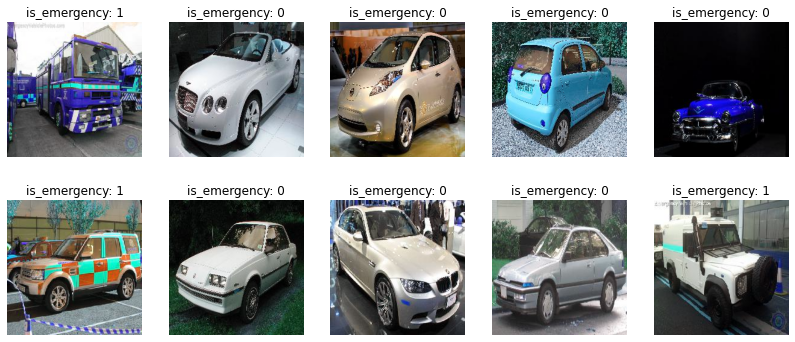

In [ ]:
# getting 10 random image names in the train directory
random_10_train_img = random.sample(os.listdir(train_dir), 10)

# creating a fiure size with a width of 14 and height of 6
plt.figure(figsize=(14, 6))

# plotting the images with the 10 random image names
for i in range(len(random_10_train_img)):
  sp = plt.subplot(2, 5, i + 1)
  sp.axis('Off')
  im = cv2.imread(os.path.join(train_dir, random_10_train_img[i]))
  label = train_df[train_df["image_names"]== random_10_train_img[i]]["emergency_or_not"].values[0]
  plt.title(f'is_emergency: {label}')
  plt.imshow(im)

In [ ]:
# checking the dimensions of the images
im.shape

(224, 224, 3)

### Data Preprocessing

In [ ]:
# creating the datagenerator that will read in the images stored as train images
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.25, 
                             horizontal_flip=True,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.20,
                             zoom_range=0.20,
                             fill_mode='nearest')

# changing the datatype of emergency_or_not column to string to be read in as the classes
train_df["emergency_or_not"] = train_df["emergency_or_not"].astype(str)

In [ ]:
# Flow training images in batches of 16 using datagen generator and resizing from 224 by 224 to 32 by 32
train_generator = datagen.flow_from_dataframe(dataframe=train_df, 
                                              directory=train_dir,
                                              subset='training',
                                              x_col='image_names',
                                              y_col='emergency_or_not',
                                              seed=42,
                                              shuffle=True,
                                              batch_size=16,
                                              class_mode='binary',
                                              target_size=(32, 32))     

# Flow validation images in batches of 16 using datagen generator and resizing from 224 by 224 to 32 by 32
validation_generator = datagen.flow_from_dataframe(dataframe=train_df, 
                                              directory=train_dir,
                                              subset='validation',
                                              x_col='image_names',
                                              y_col='emergency_or_not',
                                              seed=42,
                                              shuffle=True,
                                              batch_size=16,
                                              class_mode='binary',
                                              target_size=(32, 32))


Found 1235 validated image filenames belonging to 2 classes.
Found 411 validated image filenames belonging to 2 classes.


In [ ]:
# checking the new dimension of the training data, which should include the batch size of 16 and new pixel size of 32 instead of 224 
train_dim = next(train_generator)
print("Dimensions of a training sample",train_dim[0].shape)

# checking the new dimension of the validation data, which should include the batch size of 16 and new pixel size of 32 instead of 224 
val_dim = next(validation_generator)
print("Dimensions of a validation sample",val_dim[0].shape)

Dimensions of a training sample (16, 32, 32, 3)
Dimensions of a validation sample (16, 32, 32, 3)


### CNN

#### Modeling

##### CNN with only one convolutional layer and fully connected layer


In [ ]:
model = Sequential([
    # convolutional layer with 16 filters whose sizes are 3 by 3
    Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    # Flatten the results to feed into a DNN
    Flatten(), 
    # hidden layer with 16 neurons
    Dense(16, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 is for class ('emergence') and 1 for ('non-emergence')
    Dense(1, activation='sigmoid')  
]) 

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 flatten_8 (Flatten)         (None, 16384)             0         
                                                                 
 dense_16 (Dense)            (None, 16)                262160    
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 262,625
Trainable params: 262,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

#### Training the model 

In [ ]:
history = model.fit(
            train_generator,
            epochs=20,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/20
78/78 - 5s - loss: 0.6560 - accuracy: 0.6510 - val_loss: 0.6314 - val_accuracy: 0.6667 - 5s/epoch - 62ms/step
Epoch 2/20
78/78 - 4s - loss: 0.5824 - accuracy: 0.7190 - val_loss: 0.5891 - val_accuracy: 0.6983 - 4s/epoch - 55ms/step
Epoch 3/20
78/78 - 4s - loss: 0.5651 - accuracy: 0.7296 - val_loss: 0.5711 - val_accuracy: 0.7226 - 4s/epoch - 54ms/step
Epoch 4/20
78/78 - 7s - loss: 0.5394 - accuracy: 0.7474 - val_loss: 0.5618 - val_accuracy: 0.7324 - 7s/epoch - 88ms/step
Epoch 5/20
78/78 - 5s - loss: 0.5232 - accuracy: 0.7619 - val_loss: 0.5488 - val_accuracy: 0.7080 - 5s/epoch - 67ms/step
Epoch 6/20
78/78 - 5s - loss: 0.5253 - accuracy: 0.7457 - val_loss: 0.5604 - val_accuracy: 0.7275 - 5s/epoch - 62ms/step
Epoch 7/20
78/78 - 5s - loss: 0.5150 - accuracy: 0.7474 - val_loss: 0.5394 - val_accuracy: 0.7251 - 5s/epoch - 65ms/step
Epoch 8/20
78/78 - 5s - loss: 0.5028 - accuracy: 0.7717 - val_loss: 0.5562 - val_accuracy: 0.7275 - 5s/epoch - 69ms/step
Epoch 9/20
78/78 - 6s - loss: 0.

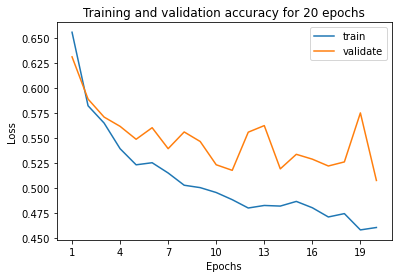

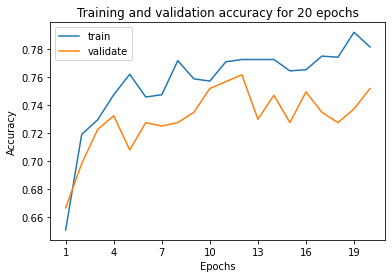

In [ ]:
# Retrieve a list of list results on training and validation data
# sets for each training epoch

train_accuracy = history.history['accuracy']
validation_accuracy  = history.history['val_accuracy']
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs   = range(1, len(train_accuracy)+1) # Get number of epochs


# Plot training and validation loss per epoch
plt.plot(epochs, train_loss, label='train')
plt.plot(epochs, validation_loss, label='validate')
plt.title(f'Training and validation accuracy for {len(epochs)} epochs')
plt.xticks([i for i in range(1, len(train_accuracy)+1, 3)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()


# Plot training and validation accuracy per epoch
plt.plot(epochs, train_accuracy, label='train')
plt.plot(epochs, validation_accuracy, label='validate')
plt.title(f'Training and validation accuracy for {len(epochs)} epochs')
plt.xticks([i for i in range(1, len(train_accuracy)+1, 3)])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

##### CNN with three convolutional layers, two pooling layers, batch normalization and fully connected layer

In [ ]:
model2 = Sequential([
    # convolutional layer with 16 filters whose sizes are 3 by 3
    Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    MaxPooling2D(2,2),
    # convolutional layer with 16 filters whose sizes are 3 by 3
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2), 
    # convolutional layer with 32 filters whose sizes are 3 by 3
    Conv2D(32, (3,3), activation='relu'),
    # normalizing the output of the convolutions before feeding it into the Dense Neural Network
    BatchNormalization(),
    # Flatten the results to feed into a DNN
    Flatten(), 
    # 16 neuron hidden layer
    Dense(16, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 is for class ('emergence') and 1 for ('non-emergence')
    Dense(1, activation='sigmoid')  
]) 

In [ ]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 16)        2320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 5, 5, 32)          4640      
                                                                 
 batch_normalization_5 (Batc  (None, 5, 5, 32)        

In [ ]:
model2.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

#### Training model2

In [ ]:
history2 = model2.fit(
            train_generator,
            epochs=20,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/20
78/78 - 5s - loss: 0.6562 - accuracy: 0.6389 - val_loss: 0.6858 - val_accuracy: 0.5718 - 5s/epoch - 70ms/step
Epoch 2/20
78/78 - 5s - loss: 0.5875 - accuracy: 0.7012 - val_loss: 0.6707 - val_accuracy: 0.6618 - 5s/epoch - 64ms/step
Epoch 3/20
78/78 - 4s - loss: 0.5353 - accuracy: 0.7547 - val_loss: 0.6213 - val_accuracy: 0.6764 - 4s/epoch - 55ms/step
Epoch 4/20
78/78 - 4s - loss: 0.5239 - accuracy: 0.7514 - val_loss: 0.5845 - val_accuracy: 0.7129 - 4s/epoch - 55ms/step
Epoch 5/20
78/78 - 4s - loss: 0.5146 - accuracy: 0.7409 - val_loss: 0.5894 - val_accuracy: 0.6764 - 4s/epoch - 56ms/step
Epoch 6/20
78/78 - 4s - loss: 0.4959 - accuracy: 0.7668 - val_loss: 0.5434 - val_accuracy: 0.7129 - 4s/epoch - 55ms/step
Epoch 7/20
78/78 - 4s - loss: 0.4910 - accuracy: 0.7668 - val_loss: 0.5540 - val_accuracy: 0.7202 - 4s/epoch - 55ms/step
Epoch 8/20
78/78 - 4s - loss: 0.4555 - accuracy: 0.8000 - val_loss: 0.5753 - val_accuracy: 0.7372 - 4s/epoch - 55ms/step
Epoch 9/20
78/78 - 4s - loss: 0.

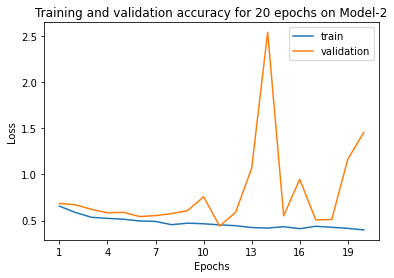

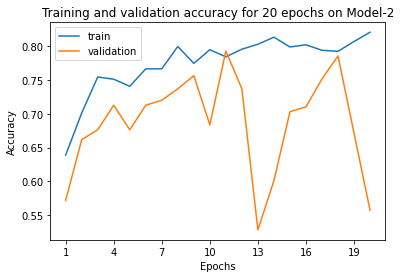

In [ ]:
# Retrieve a list of list results on training and validation data
# sets for each training epoch

train_accuracy2 = history2.history['accuracy']
validation_accuracy2  = history2.history['val_accuracy']
train_loss2 = history2.history['loss']
validation_loss2 = history2.history['val_loss']

epochs2   = range(1, len(train_accuracy2)+1) # Get number of epochs


# Plot training and validation loss per epoch
plt.plot(epochs2, train_loss2, label='train')
plt.plot(epochs2, validation_loss2, label='validation')
plt.title(f'Training and validation accuracy for {len(epochs2)} epochs on Model-2')
plt.xticks([i for i in range(1, len(train_accuracy2)+1, 3)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()


# Plot training and validation accuracy per epoch
plt.plot(epochs2, train_accuracy2, label='train')
plt.plot(epochs2, validation_accuracy2, label='validation')
plt.title(f'Training and validation accuracy for {len(epochs2)} epochs on Model-2')
plt.xticks([i for i in range(1, len(train_accuracy2)+1, 3)])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

#### CNN with Early Stopping

In [ ]:
# callbacks = [EarlyStopping(monitor='val_loss', patience=3),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# use the EarlyStopping to avoid overfitting by monitoring the validation loss. Save the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model1.h5', monitor='val_loss', save_best_only=True)]

#### Training Model3

In [ ]:
model3 = Sequential([
    # convolutional layer with 16 filters whose sizes are 3 by 3
    Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    MaxPooling2D(2,2),
    # convolutional layer with 16 filters whose sizes are 3 by 3
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # convolutional layer with 32 filters whose sizes are 3 by 3 
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    # Flatten the results to feed into a DNN
    Flatten(), 
    # 16 neuron hidden layer
    Dense(16, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 is for class ('emergence') and 1 for ('non-emergence')
    Dense(1, activation='sigmoid')  
]) 

In [ ]:
model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 16)        2320      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 5, 5, 32)          4640      
                                                                 
 batch_normalization_10 (Bat  (None, 5, 5, 32)       

In [ ]:
model3.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history3 = model3.fit(
            train_generator,
            epochs=20,
            validation_data=validation_generator,
            verbose=2,
            callbacks = callbacks
            )

Epoch 1/20
78/78 - 5s - loss: 0.6639 - accuracy: 0.6397 - val_loss: 0.6632 - val_accuracy: 0.6302 - 5s/epoch - 69ms/step
Epoch 2/20
78/78 - 4s - loss: 0.5858 - accuracy: 0.6923 - val_loss: 0.6749 - val_accuracy: 0.6156 - 4s/epoch - 54ms/step
Epoch 3/20
78/78 - 4s - loss: 0.5434 - accuracy: 0.7433 - val_loss: 0.6002 - val_accuracy: 0.6959 - 4s/epoch - 54ms/step
Epoch 4/20
78/78 - 4s - loss: 0.5304 - accuracy: 0.7401 - val_loss: 0.6144 - val_accuracy: 0.7178 - 4s/epoch - 55ms/step
Epoch 5/20
78/78 - 4s - loss: 0.5021 - accuracy: 0.7579 - val_loss: 0.5331 - val_accuracy: 0.7397 - 4s/epoch - 55ms/step
Epoch 6/20
78/78 - 4s - loss: 0.5092 - accuracy: 0.7466 - val_loss: 0.5684 - val_accuracy: 0.7202 - 4s/epoch - 54ms/step
Epoch 7/20
78/78 - 4s - loss: 0.4874 - accuracy: 0.7684 - val_loss: 0.6257 - val_accuracy: 0.6667 - 4s/epoch - 55ms/step
Epoch 8/20
78/78 - 4s - loss: 0.4860 - accuracy: 0.7563 - val_loss: 0.5242 - val_accuracy: 0.7445 - 4s/epoch - 56ms/step
Epoch 9/20
78/78 - 4s - loss: 0.

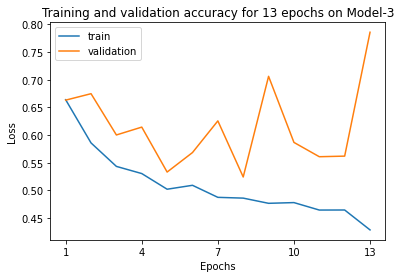

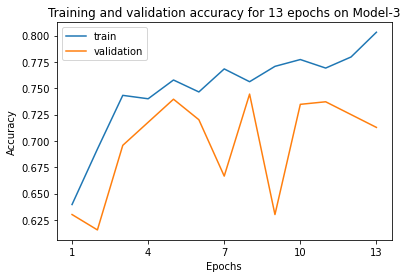

In [ ]:
# Retrieve a list of list results on training and validation data
# sets for each training epoch

train_accuracy3 = history3.history['accuracy']
validation_accuracy3  = history3.history['val_accuracy']
train_loss3 = history3.history['loss']
validation_loss3 = history3.history['val_loss']

epochs3   = range(1, len(train_accuracy3)+1) # Get number of epochs


# Plot training and validation loss per epoch
plt.plot(epochs3, train_loss3, label='train')
plt.plot(epochs3, validation_loss3, label='validation')
plt.title(f'Training and validation accuracy for {len(epochs3)} epochs on Model-3')
plt.xticks([i for i in range(1, len(train_accuracy3)+1, 3)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()


# Plot training and validation accuracy per epoch
plt.plot(epochs3, train_accuracy3, label='train')
plt.plot(epochs3, validation_accuracy3, label='validation')
plt.title(f'Training and validation accuracy for {len(epochs3)} epochs on Model-3')
plt.xticks([i for i in range(1, len(train_accuracy3)+1, 3)])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

#### Evaluate the model

In [ ]:
print(history3.history["val_accuracy"][-1])

0.712895393371582


#### Predict on Test Set

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# creating empty dataframe to hold image names and resulting labels
df = pd.DataFrame(columns=['image_names', 'emergence_or_not'])
# getting the image names in the test data
for img_name in os.listdir(test_dir):
  
  # getting the paths of each image in the test data
  img_path = os.path.join(test_dir, img_name)

  # loading each image in the test data
  img = load_img(img_path, target_size=(32, 32))
  # getting the array representation of each image
  img_as_array = img_to_array(img)

  # rescale images
  img_as_array/=255
  img_as_array=np.expand_dims(img_as_array, axis=0)
  images = np.vstack([img_as_array])
  
  classes = model.predict(images, batch_size=2)
  if classes[0]>0.5:
    df = df.append({'image_names':img_name,
                    'emergence_or_not': int(1)}, ignore_index=True)
  else:
    df = df.append({'image_names':img_name,
                    'emergence_or_not': int(0)}, ignore_index=True)

1/1 [==============================] - 0s 23ms/step


In [ ]:
df

,image_names,emergence_or_not
0,1050.jpg,0
1,1053.jpg,0
2,1047.jpg,0
3,1054.jpg,0
4,1014.jpg,0
...,...,...
701,422.jpg,1
702,377.jpg,1
703,869.jpg,1
704,792.jpg,1


In [ ]:
# save the resulting dataframe with the predictions in a csv file
df.to_csv('emergency_vehicles_or_not_predictions.csv')